# Some basics of ROOT and RooFit

* ROOT documentation starts at: https://root.cern.ch/doc/master/
* RooFit is a very advanced multivariate fitting package. Tutorials start here: https://root.cern.ch/root/htmldoc/tutorials/roofit/index.html
* ROOT and RooFit are written in C++, and use the Minuit fitting package to perform minimization. Minuit is very advanced.
* Fitting numerically often is unstable. Stability is improved if there is an analytical method for integration and differentiation of the fit function in multiple directions. For this reason, RooFit comes with a lot of pre-compiled fuctions with known integrals and differentials, and these are forwarded to Minuit.

# RooFit functions

* Many functions accept RooCmdArgs, to steer the processing, a complete list is here: https://root.cern.ch/doc/master/RooGlobalFunc_8h.html
* Here is a list of some-prebuilt PDFs, advanced users will program their own in C++: https://root.cern.ch/doc/master/dir_41a638b8e8a0cd258b1eda9652624ad1.html
* RooRealVars are the variables to be fit. They can be combined together to create funtional PDF descriptions, and then PDFs can be combined together in multidimentional ways in order to construct a very high dimensional PDF.
* The higher the dimensions, the more difficult the fit, and the more data are required to converge.


In [1]:
import sys
import os
if 'seaborn' not in sys.modules:
    import numpy as np
    import pandas as pd
    %pylab inline
    import seaborn
    import rwlstats
    from scipy import stats
    from scipy.stats import ttest_ind
    from pylab import pcolor
    import rootnotes
    import root_pandas
    from root_pandas import read_root
    import json
    import requests
    import subprocess as subp
    import ROOT

Populating the interactive namespace from numpy and matplotlib


In [2]:
from ROOT import RooRealVar, RooFormulaVar, RooVoigtian, RooChebychev, RooArgList, \
                 RooArgSet, RooAddPdf, RooDataSet, RooCategory, RooSimultaneous, \
                 RooBreitWigner, RooCBShape, RooFFTConvPdf, RooGaussian, RooProdPdf, \
                 RooAbsData

In [3]:
# The default storage type in RooFit is a vector. Vectors are much faster, but harder to play around with in python/pandas
RooDataSet.setDefaultStorageType(RooAbsData.Tree)

In [4]:
# Root needs a file for saving information, let's make a temp file for this session
from ROOT import TFile
import tempfile
tdir = tempfile.mkdtemp()
thefile = TFile(tdir + 'roofit_tut.root', 'RECREATE')
thefile.Write()
thefile.cd()

True

# Create double gauss PDF in RooFit

In [5]:
# Making a double Gaussian in RooFit. First, make some variables.
#var  = RooRealVar('name', 'title', val, min, max)
mean1 = RooRealVar('mean1', 'mean of first Gaussian', 2, -10, 10)
mean2 = RooRealVar('mean2', 'mean of second Gaussian', 1, -10, 10)
sigma1 = RooRealVar('sigma1', 'std of first Gaussian', 0.5, 0.01, 10)
sigma2 = RooRealVar('sigma2', 'std of second Gaussian', 1, 0.01, 5)

x = RooRealVar('x', 'x variable', 2, -20, 20)
y = RooRealVar('y', 'y variable', 2, -20, 20)

In [6]:
# First Gaussian
gauss_x = RooGaussian('gauss_x', "Gaussian in x-direction", x, mean1, sigma1)
gauss_y = RooGaussian('gauss_y', "Gaussian in y-direction", y, mean2, sigma2)

gauss_2d = RooProdPdf('gauss_2d', 'Gaussian in 2 dimensions', RooArgList(gauss_x, gauss_y))

In [7]:
can = rootnotes.canvas('c1')
xframe = x.frame()
gauss_x.plotOn(xframe)
xframe.Draw('c1')

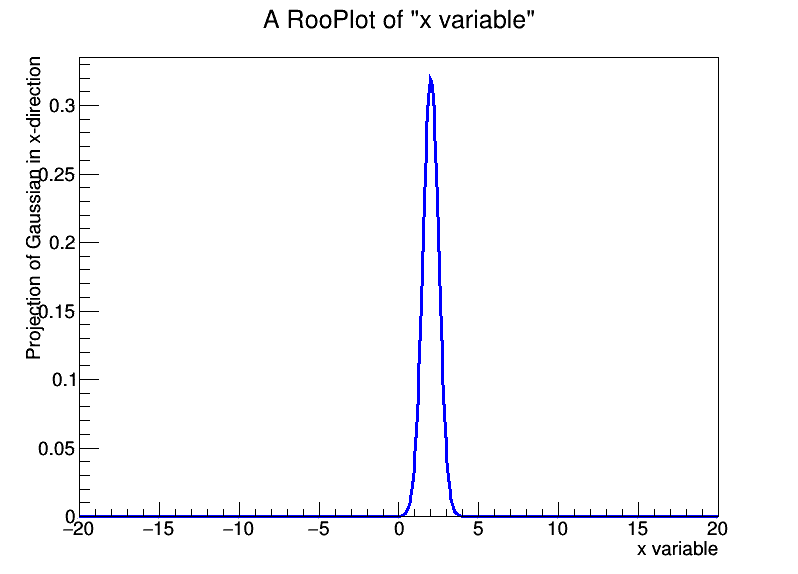

<ROOT.TCanvas object ("c1") at 0x5a56e20>

In [8]:
can

# Generate some data with this PDF

In [9]:
generated = gauss_2d.generate(RooArgSet(x,y),10000)

# Make some plots in pandas and root

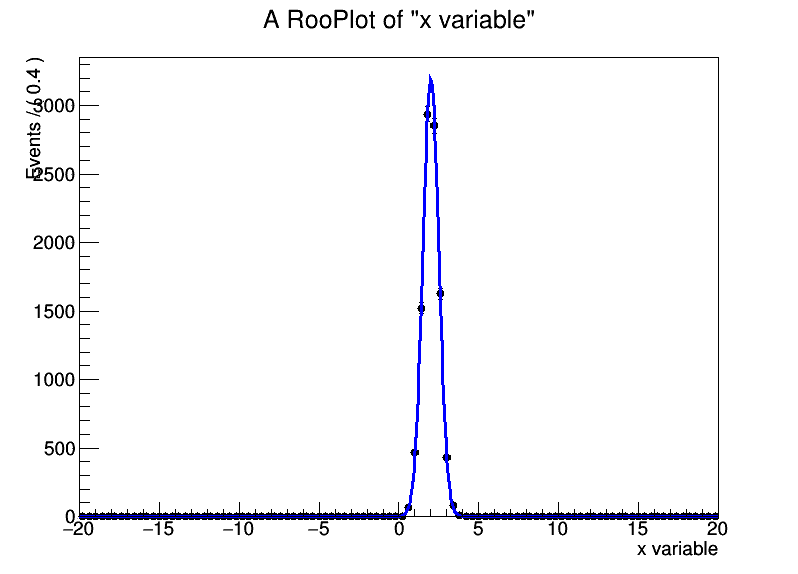

<ROOT.TCanvas object ("c2") at 0x5b8ec60>

In [10]:
can = rootnotes.canvas('c2')
xframe = x.frame()
generated.plotOn(xframe)
gauss_x.plotOn(xframe)
xframe.Draw('c2')
can

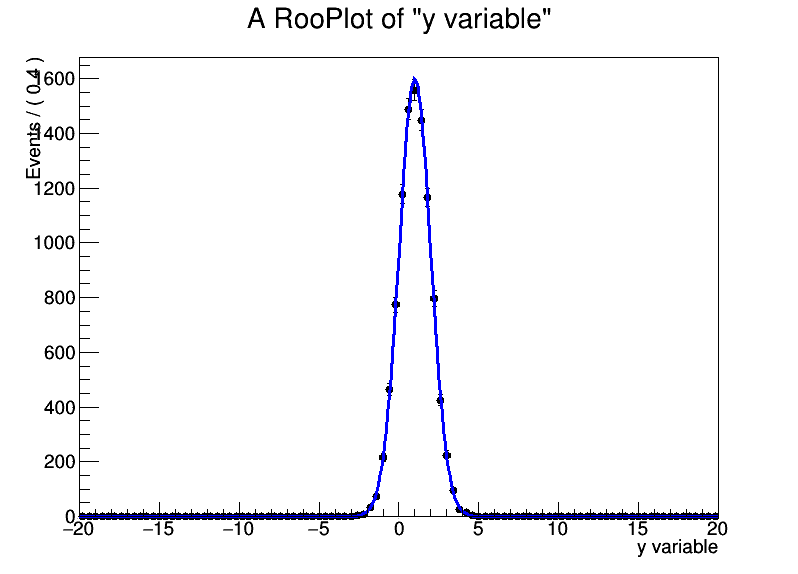

<ROOT.TCanvas object ("c3") at 0x5c1e220>

In [11]:
can = rootnotes.canvas('c3')
yframe = y.frame()
generated.plotOn(yframe)
gauss_y.plotOn(yframe)
yframe.Draw('c3')
can

In [12]:
# plot 2D histogram
tree = generated.tree()
generated.tree().Write()

144820

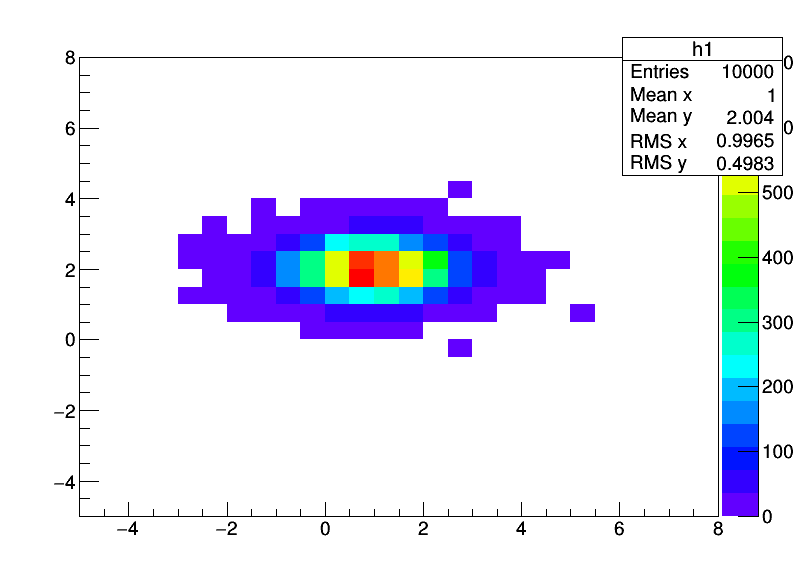

<ROOT.TCanvas object ("c4") at 0x5dff1e0>

In [13]:
can = rootnotes.canvas('c4')
can.cd()
th2d = rootnotes.TH2D(26,-5,8,26,-5,8)
generated.tree().Draw('x:y>>'+th2d.GetName(),"","colz")
can

In [14]:
ROOT.TBrowser()

<ROOT.TBrowser object ("Browser") at 0x5fc7d60>

In [15]:
df_generated = read_root(thefile.GetName(), generated.GetName())

In [16]:
df_generated.head()

,x,y
0,2.499466,0.565236
1,2.390898,0.969947
2,2.412132,0.943283
3,1.549562,0.925296
4,2.003956,0.589237


In [17]:
import copy; cmap=copy.copy(matplotlib.cm.jet); cmap._init(); cmap._lut[0] = (1,1,1,1)

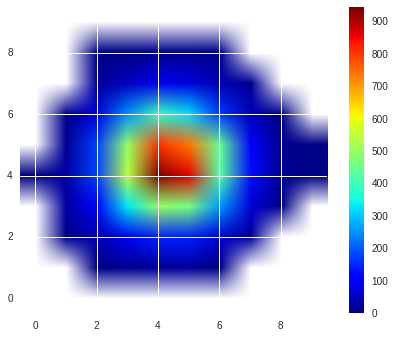

In [18]:
plt.imshow(np.histogram2d(df_generated.x, df_generated.y)[0], cmap=cmap, origin='lower')
plt.colorbar()

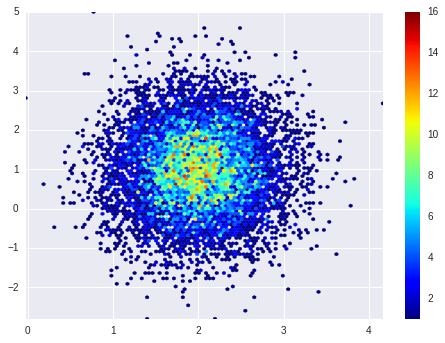

In [19]:
plt.hexbin(df_generated.x,df_generated.y, cmap='jet', mincnt=1)
plt.colorbar()

# Fit the data with the PDF

In [20]:
#Let's be fair by setting the values to strage things here ...
mean1.setVal(2)
mean2.setVal(4)
sigma1.setVal(1.1)
sigma2.setVal(1)

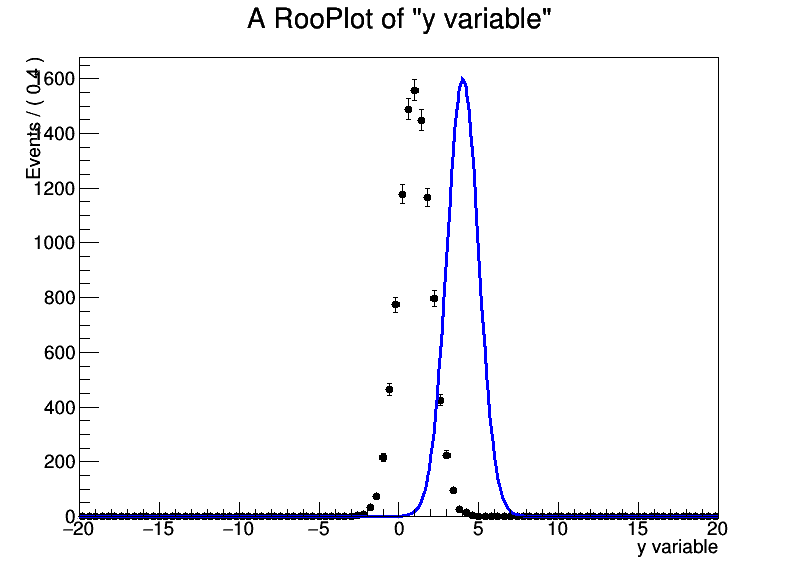

<ROOT.TCanvas object ("c3") at 0x5c1e220>

In [21]:
can = rootnotes.canvas('c3')
yframe = y.frame()
generated.plotOn(yframe)
gauss_y.plotOn(yframe)
yframe.Draw('c3')
can

In [22]:
## The fitTo method returns a RooFitResult, with a lot of information

In [23]:
%%rootprint
results = gauss_2d.fitTo(generated, ROOT.RooFit.Save())

[#1] INFO:Minization -- RooMinuit::optimizeConst: activating const optimization
[#0] WARNING:Optimization -- RooAbsOptTestStatistic::optimizeConstantTerms(nll_gauss_2d_gauss_2dData) WARNING Cache-and-track optimization (Optimize level 2) is only available for datasets implement in terms of RooVectorDataStore - ignoring this option for current dataset
 **********
 **   13 **MIGRAD        2000           1
 **********
 FIRST CALL TO USER FUNCTION AT NEW START POINT, WITH IFLAG=4.
 START MIGRAD MINIMIZATION.  STRATEGY  1.  CONVERGENCE WHEN EDM .LT. 1.00e-03
 FCN=66382.6 FROM MIGRAD    STATUS=INITIATE       38 CALLS          39 TOTAL
                     EDM= unknown      STRATEGY= 1      NO ERROR MATRIX       
  EXT PARAMETER               CURRENT GUESS       STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  mean1        2.00000e+00   2.00000e+00   0.00000e+00  -1.59654e+03
   2  mean2        4.00000e+00   2.00000e+00   0.00000e+00   2.7495

In [24]:
results.covQual()

3

In [25]:
results.status()

0

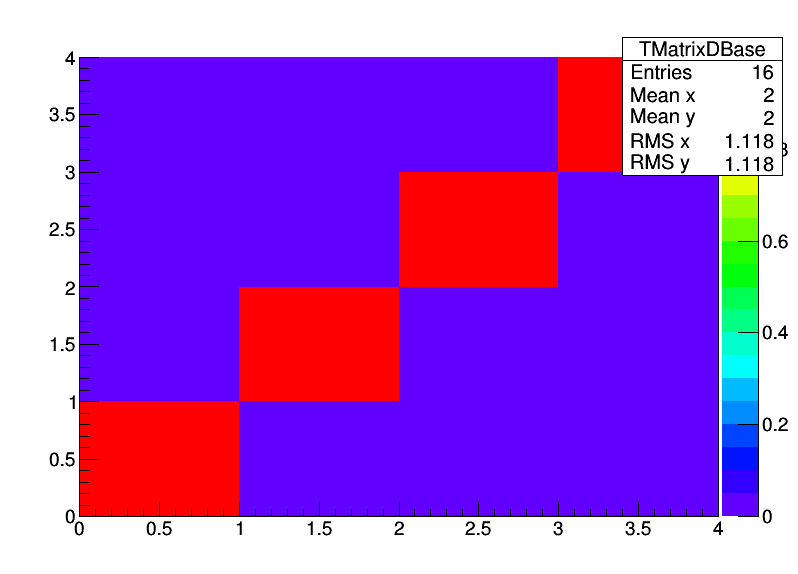

<ROOT.TCanvas object ("c3") at 0x5c1e220>

In [26]:
#%%rootprint
can.cd()
results.correlationMatrix().Draw("colz")
can

In [27]:
%%rootprint
results.covarianceMatrix().Print()


4x4 matrix is as follows

     |      0    |      1    |      2    |      3    |
---------------------------------------------------------
   0 |  2.483e-05  -4.432e-13   2.462e-09  -3.135e-13 
   1 | -4.432e-13   9.929e-05  -1.379e-16   1.052e-08 
   2 |  2.462e-09  -1.379e-16   1.241e-05  -4.432e-13 
   3 | -3.135e-13   1.052e-08  -4.432e-13   4.965e-05 




In [28]:
mean1.getVal(), mean1.getError()

(2.003891493604815, 0.004983033956618144)

## now that the fit is done, let's plot the resulting functions

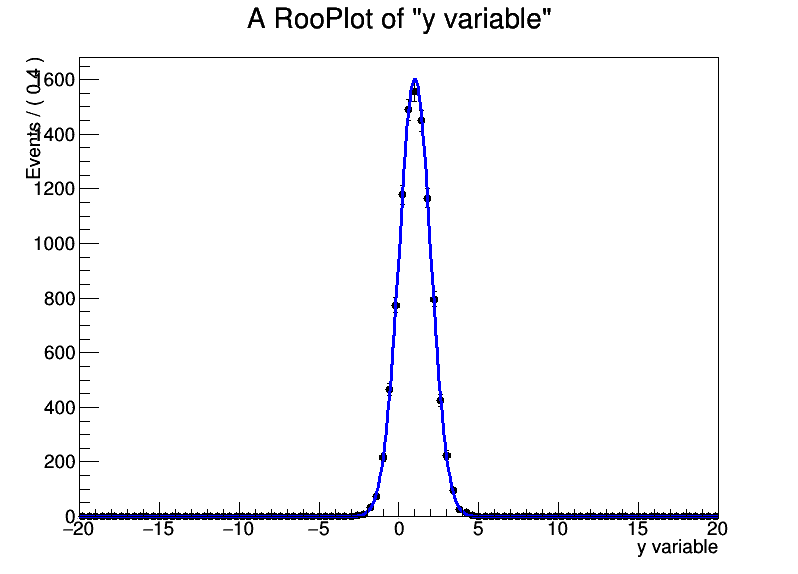

<ROOT.TCanvas object ("c3") at 0x5c1e220>

In [29]:
can = rootnotes.canvas('c3')
yframe = y.frame()
generated.plotOn(yframe)
gauss_y.plotOn(yframe)
yframe.Draw('c3')
can

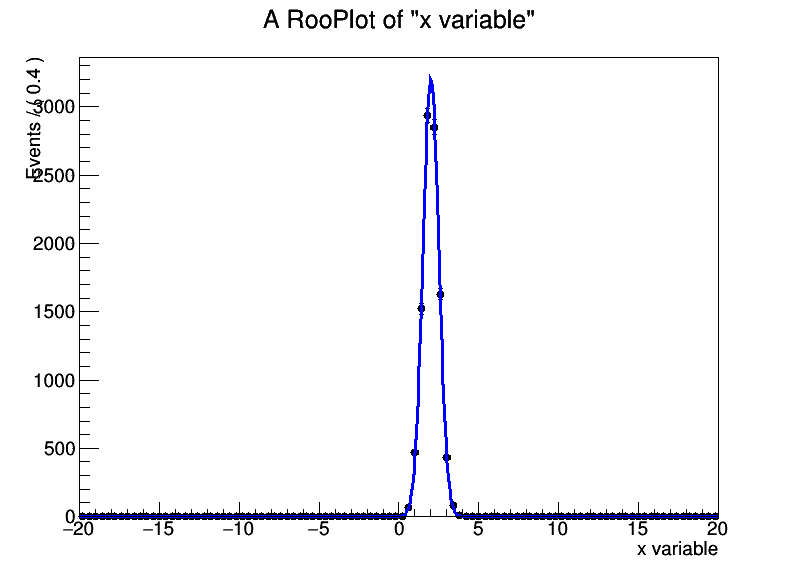

<ROOT.TCanvas object ("c2") at 0x5b8ec60>

In [30]:
can = rootnotes.canvas('c2')
xframe = x.frame()
generated.plotOn(xframe)
gauss_x.plotOn(xframe)
xframe.Draw('c2')
can